# Design trap layout

This notebook sets up the trap layout for the ACQMED experiment

In [2]:
import numpy as np
from pulser import Pulse, Sequence, Register
from pulser.devices import IroiseMVP, VirtualDevice, MockDevice, Device
from pulser.channels import Rydberg
from pulser.waveforms import CustomWaveform
from pulser_simulation import Simulation, SimConfig
from pulser.register.register_layout import RegisterLayout
import qutip
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pickle
import sys
sys.path.append('../code/')
import benchmark_utils as bmu
import density_utils as du
from pulser.channels.eom import RydbergBeam, RydbergEOM

In [3]:
import importlib
importlib.reload(bmu)
importlib.reload(du);

In [4]:
# import global variables

%store -r Fresnel
%store -r rc
%store -r spacing
%store -r brad
%store -r omega

In [5]:
d_list = [-1.0, -0.5, 0.0, 0.5, 1.0, 1.5]

# import slices
path = "../MUP1/MUP1_logfilter8_slices/"
basename = "_density_slice_MUP1_logfilter8.p"
densities = []
for d in d_list:
    filename = path + f"d{d}" + basename
    with open(filename, 'rb') as file_in:
         densities.append(pickle.load(file_in))
            
# import slice coordinates
path = "../MUP1/MUP1_logfilter8_points/"
basename = "_plane_points_MUP1.p"
points = []
for d in d_list:
    filename = path + f"d{d}" + basename
    with open(filename, 'rb') as file_in:
         points.append(pickle.load(file_in))
            
# best bitstrings as given by the Rydberg Hamiltonian
best_bitstrings = ['0010', '0001000000', '0001000000010', '00001000000010', '001000001000', '001000']

[0. 0.]


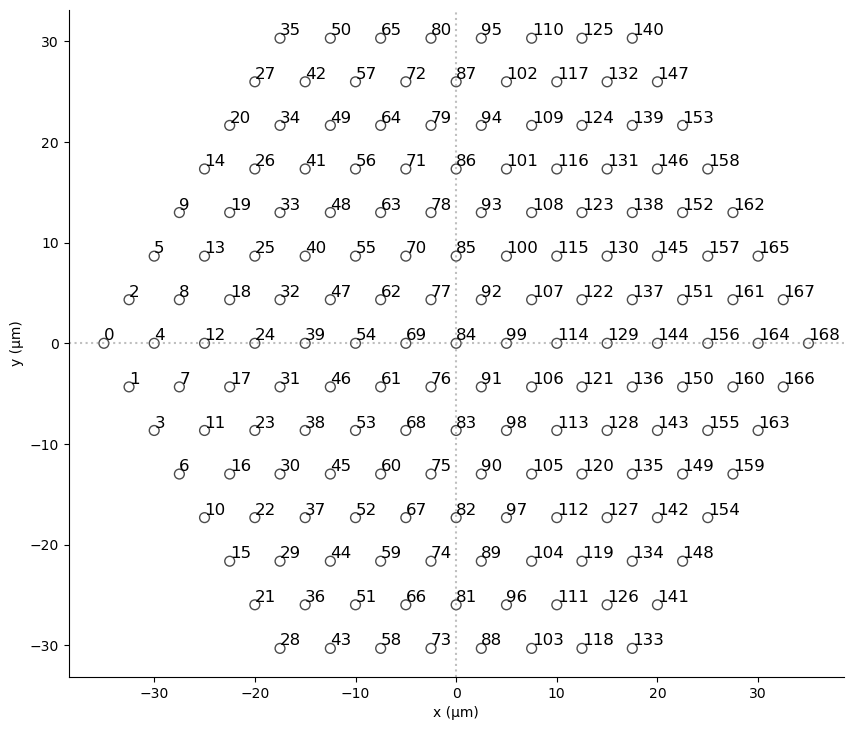

In [6]:
#full_auxreg = Register.triangular_lattice(rows=rc, atoms_per_row=int(np.round(np.sqrt(3)*rc/2)), spacing=spacing)
full_auxreg = Register.hexagon(7, spacing=spacing) 

full_trap_pos = np.array(full_auxreg._coords)
full_trap_center = du.select_middle_coordinate(full_trap_pos, full_trap_pos)
print(full_trap_center)
full_trap_layout = RegisterLayout(full_trap_pos)
full_trap_layout.draw()

Processing density 0 of 6


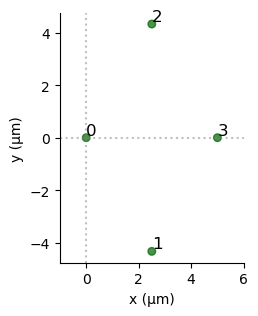

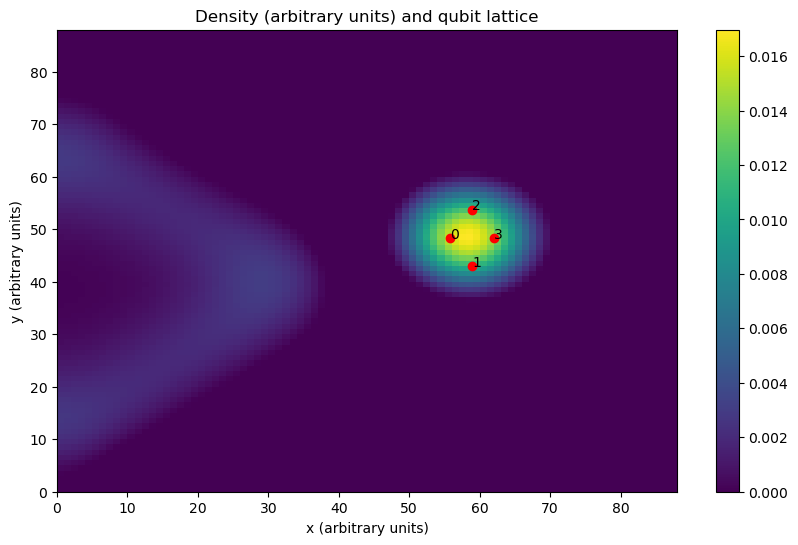

Processing density 1 of 6


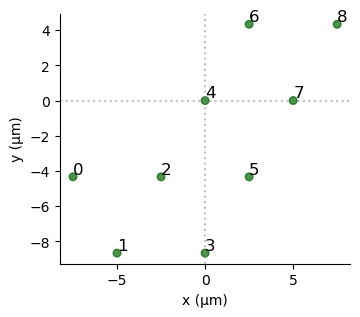

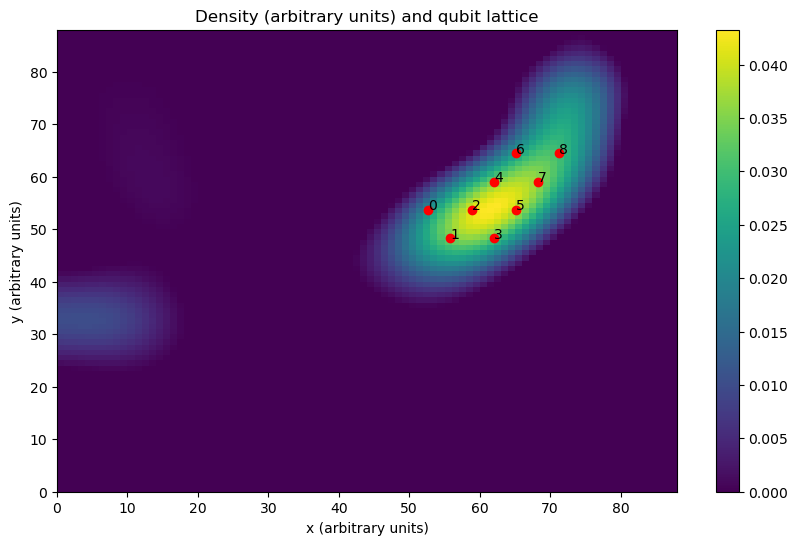

Processing density 2 of 6


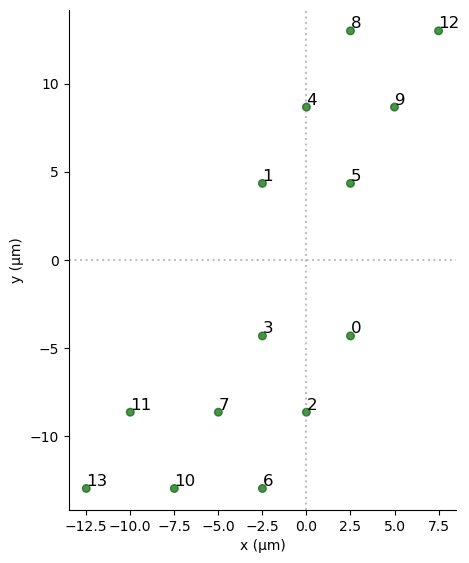

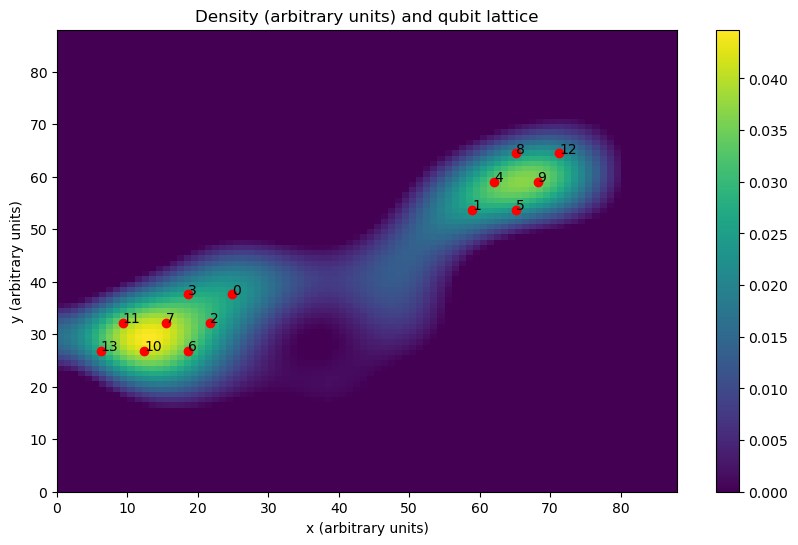

Processing density 3 of 6


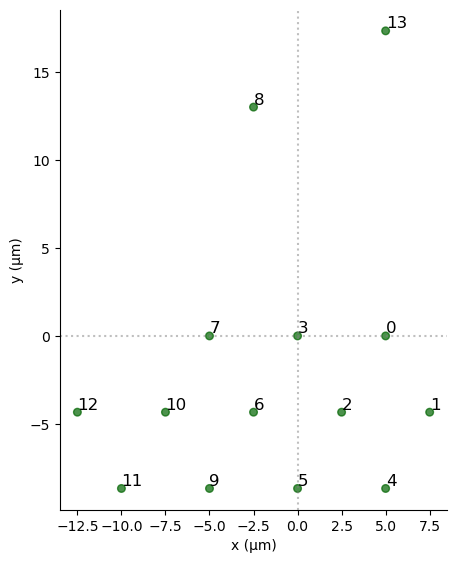

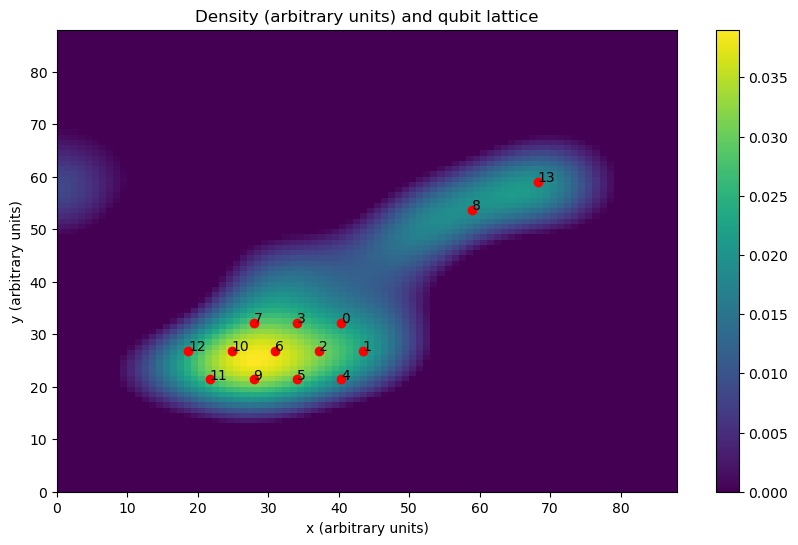

Processing density 4 of 6


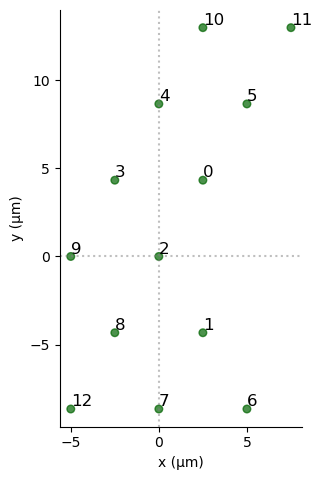

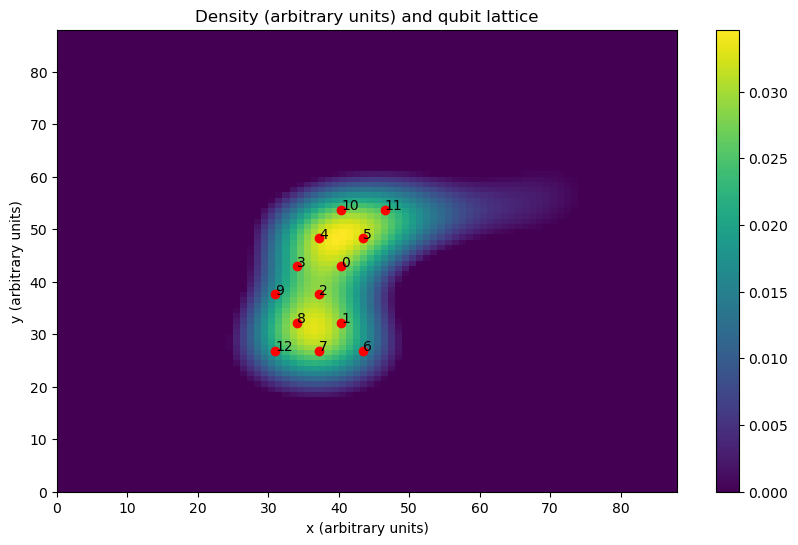

Processing density 5 of 6


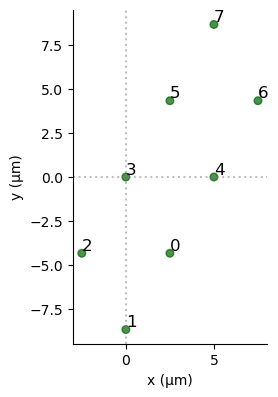

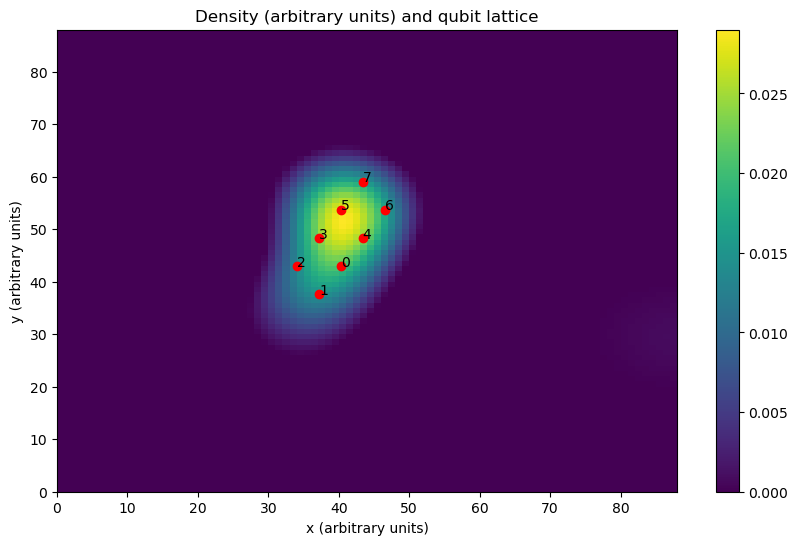

In [7]:
# Visualize registers and densities

unit_vectors = [np.array([-spacing, 0]), np.array([-spacing/2, -np.sqrt(3)*spacing/2])]

positions = []
registers = []
rescaled_positions= []

for i, density in enumerate(densities):
    print(f"Processing density {i} of {len(densities)}")
    rescaled_full_trap_pos = du.rescale_register(full_trap_pos, density)
    ''''''
    if i==2:
        reg, pos, rescaled_pos = du.decimate_register(full_trap_pos, rescaled_full_trap_pos, density, 0.48, center=full_trap_center, movement=(6,1), indices=[1,4,5,8,9,12], unit_vectors=unit_vectors)
    elif i==3:
        reg, pos, rescaled_pos = du.decimate_register(full_trap_pos, rescaled_full_trap_pos, density, 0.48, center=full_trap_center, movement=(4,1), indices=[8,13], unit_vectors=unit_vectors)
    else:
        reg, pos, rescaled_pos = du.decimate_register(full_trap_pos, rescaled_full_trap_pos, density, 0.48, center=full_trap_center)
    ''''''
    #reg, pos, rescaled_pos = du.decimate_register(full_trap_pos, rescaled_full_trap_pos, density, 0.48, center=full_trap_center)
    registers.append(reg)
    positions.append(pos)
    rescaled_positions.append(rescaled_pos)
    reg.draw()
    test_seq = Sequence(reg, Fresnel)
    
    fig, ax = plt.subplots(figsize=(10,6))
    c = ax.pcolormesh(density)
    ax.set_title("Density (arbitrary units) and qubit lattice")
    ax.set_xlabel("x (arbitrary units)")
    ax.set_ylabel("y (arbitrary units)")
    fig.colorbar(c, ax=ax)
    ax.scatter(rescaled_pos[:,0], rescaled_pos[:,1], c='red')
    for k, p in enumerate(rescaled_pos):
        plt.annotate(str(k), xy=(p[0], p[1]), xytext=(p[0], p[1]))
    plt.show()

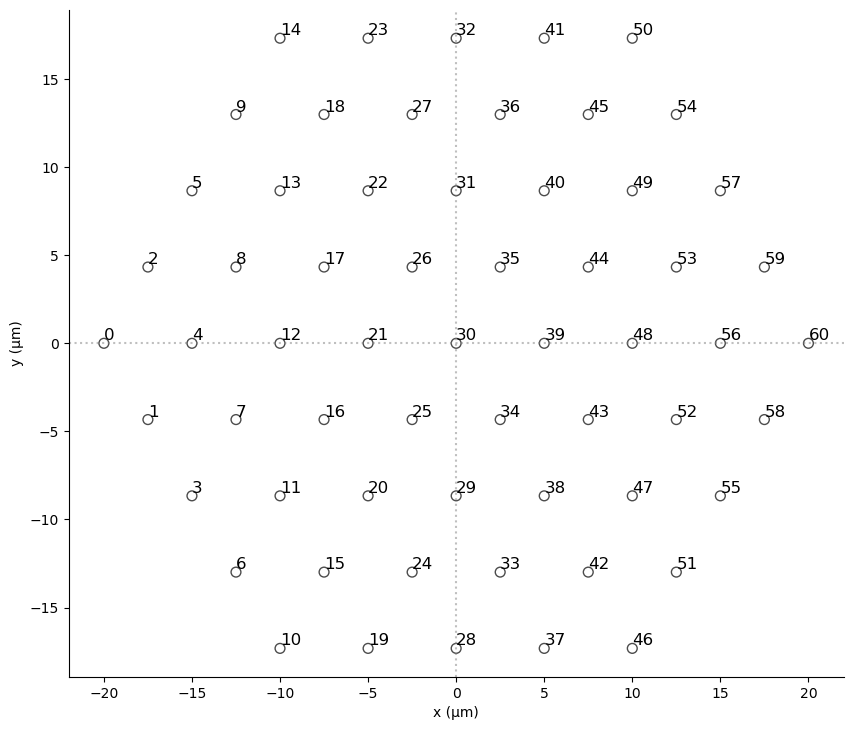

[[30, 34, 35, 39], [16, 20, 25, 29, 30, 34, 35, 39, 44], [34, 26, 29, 25, 31, 35, 24, 20, 36, 40, 15, 11, 45, 6], [39, 43, 34, 30, 38, 29, 25, 21, 27, 20, 16, 11, 7, 41], [35, 34, 30, 26, 31, 40, 38, 29, 25, 21, 36, 45, 20], [34, 29, 25, 30, 39, 35, 44, 40]]


In [8]:
trap_list = []
auxreg = Register.hexagon(4, spacing=spacing) 
trap_pos = np.array(auxreg._coords)
trap_layout = RegisterLayout(trap_pos)
trap_layout.draw()
for pos in positions:
    trap_list.append(trap_layout.get_traps_from_coordinates(*pos))
print(trap_list)


## Write layout and trap indices on file

In [107]:
with open('trap_layout/trap_layout_pos.npy', 'wb') as file_out:
    np.save(file_out, trap_pos)

In [108]:
with open('trap_layout/trap_layout_pos.npy', 'rb') as file_in:
    test = np.load(file_in)
assert(np.all(test == trap_pos))

In [109]:
for i, idx in enumerate(trap_list):
    with open(f'trap_layout/trap_indices_{i}.npy', 'wb') as file_out:
        np.save(file_out, idx)

In [110]:
for i, idx in enumerate(trap_list):
    with open(f'trap_layout/trap_indices_{i}.npy', 'rb') as file_in:
        test = np.load(file_in)
        assert(np.all(test == idx))

In [111]:
for i, pos in enumerate(positions):
    with open(f'registers/position_{i}.npy', 'wb') as file_out:
        np.save(file_out, pos)

for i, res_pos in enumerate(rescaled_positions):
    with open(f'registers/rescaled_position_{i}.npy', 'wb') as file_out:
        np.save(file_out, res_pos)

In [112]:
for i, pos in enumerate(positions):
    with open(f'registers/position_{i}.npy', 'rb') as file_in:
        test = np.load(file_in)
        assert(np.all(pos == test))

for i, res_pos in enumerate(rescaled_positions):
    with open(f'registers/rescaled_position_{i}.npy', 'rb') as file_in:
        test = np.load(file_in)
        assert(np.all(res_pos == test))

## Last visual check that everything is in order

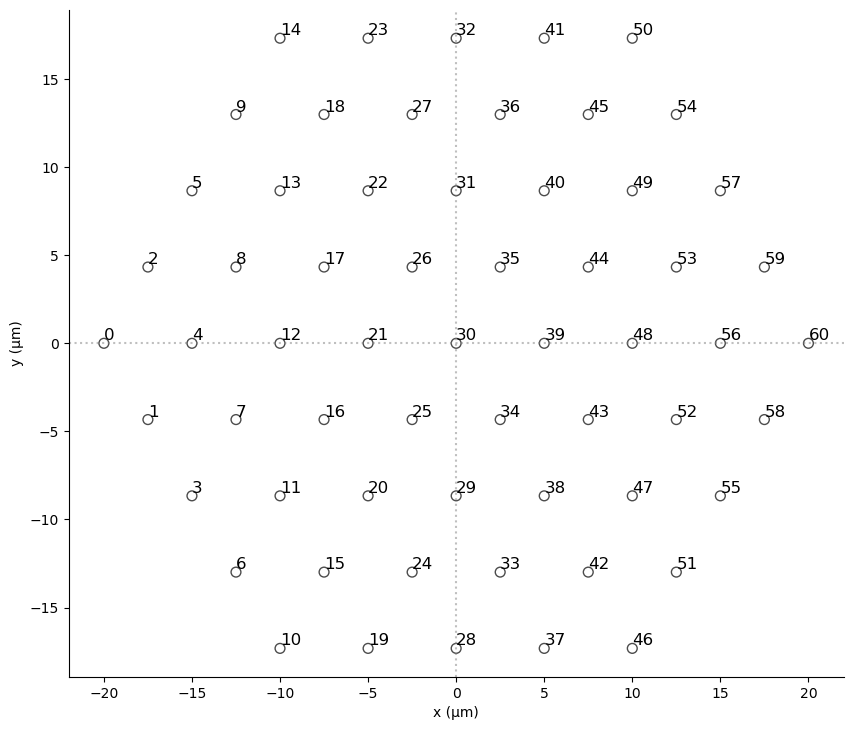

In [9]:
trap_layout.draw()

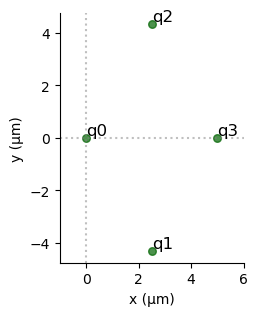

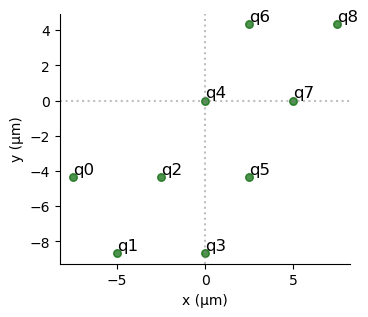

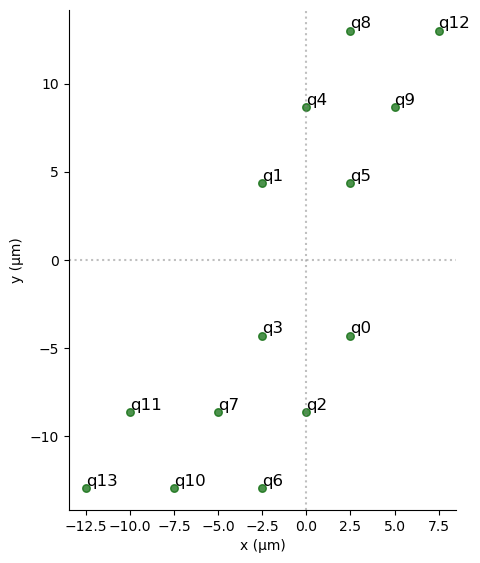

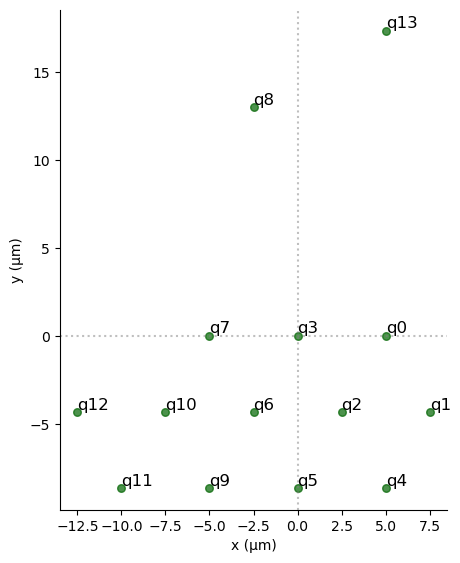

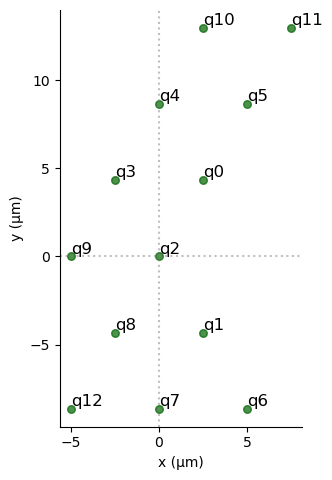

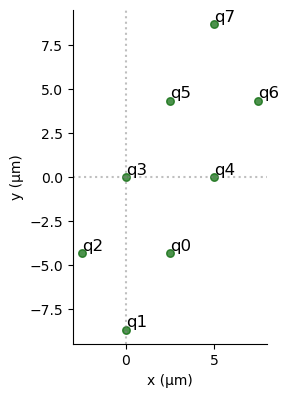

In [114]:
for i, idx in enumerate(trap_list):
    temp_reg = trap_layout.define_register(*idx)
    temp_reg.draw()

## Draw

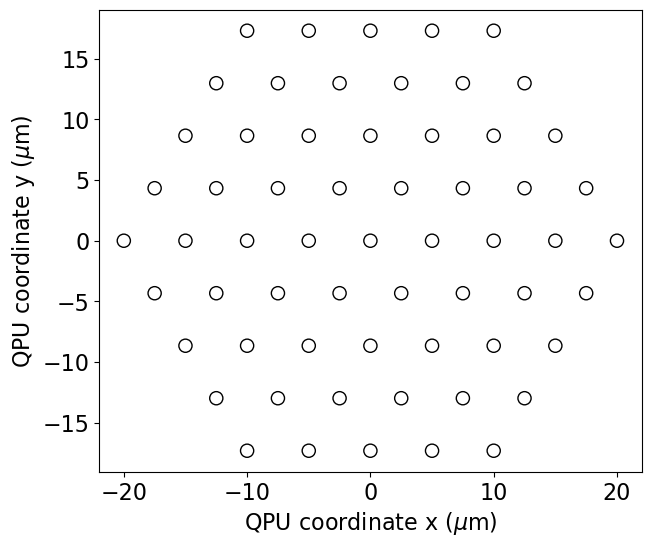

In [29]:
import matplotlib as mpl
mpl.rc('font', size=16)

plt.figure(figsize=(7,6))
plt.scatter(trap_layout.coords[:,0], trap_layout.coords[:,1], facecolors='none', s=90, edgecolors='k') 
plt.xlabel("QPU coordinate x ($\mu$m)")
plt.ylabel("QPU coordinate y ($\mu$m)")
#plt.title("Trap layout")
plt.savefig("figures/traps.png")

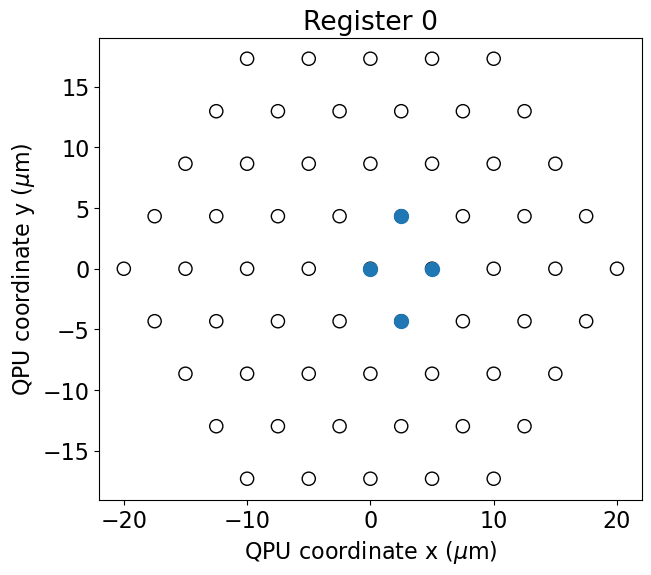

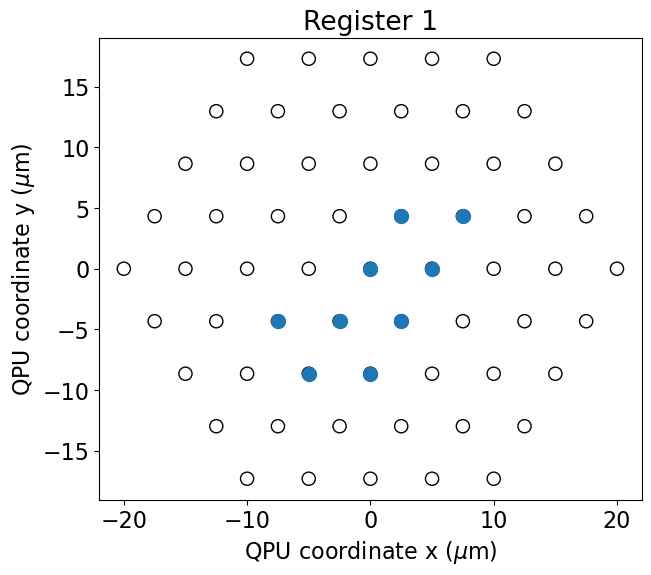

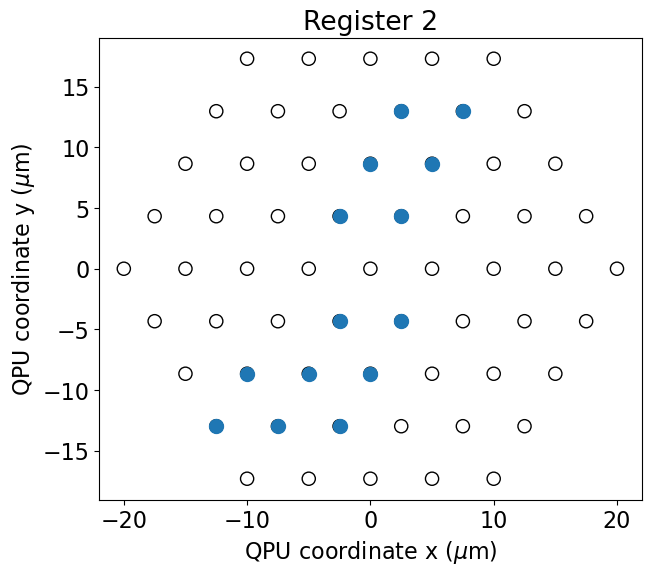

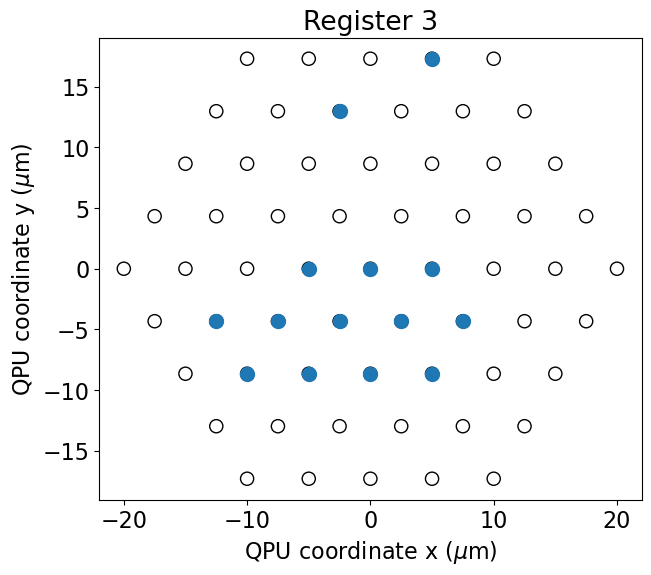

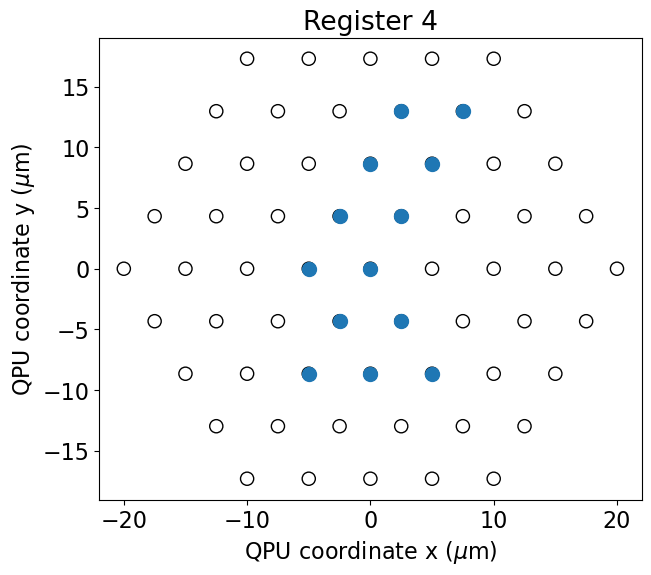

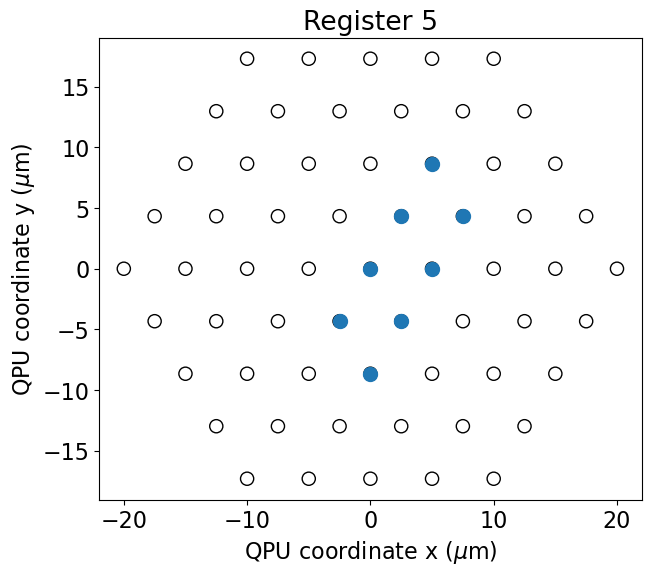

In [28]:
for i, idx in enumerate(trap_list):
    temp_reg = trap_layout.define_register(*idx)
    coords = np.array(temp_reg._coords)
    plt.figure(figsize=(7,6))
    plt.scatter(trap_layout.coords[:,0], trap_layout.coords[:,1], facecolors='none', s=90, edgecolors='k') 
    plt.scatter(coords[:,0], coords[:,1], s=100, color='tab:blue') 
    plt.xlabel("QPU coordinate x ($\mu$m)")
    plt.ylabel("QPU coordinate y ($\mu$m)")
    plt.title(f"Register {i}")
    plt.savefig(f"figures/traps_and_reg{i}.png")